# Reproducing JPM’s US Rates Strategy RV Trade Idea

Medium Post: https://medium.com/@cleeclee/reproducing-jpms-us-rates-strategy-rv-trade-idea-6b38e89791d0

Jay Barry (J.P. Morgan’s Co-head of U.S. Rates Strategy) and team recently initiated a 3.125% Nov-41/ 2% Nov-41 flattener in their flagship “U.S. Fixed Income Markets Weekly” report from 20 September 2024. Here’s the snippet:

```
Turning to relative value, we’ve noticed that originally issued 20-year bonds maturing in late-2041 and early-2042 have cheapened relative to our par curve, whereas originally issued 30-year bonds with similar maturities have outperformed. Clearly, the recent steepening of the Treasury curve supports wider yield spreads between higher-coupon OI 30s, and lower-coupon OI 20s with the same maturity, given significant duration differences. However, this dynamic is not explained by duration profiles: Figure 20 displays the securities in the 2040–2043 basket, sorted by modified duration and shows that late-41/ early-42 OI 30s appear rich relative to other securities with similar duration. In particular, the 3.125% Nov-41/ 2% Nov-41 curve appears 5.0bp too steep relative to the shape of the 15s/20s Treasury par curve (Figure 21). Hence, we recommend initiating 91:100 weighted 3.125% Nov-41/ 2% Nov-41 flatteners (see Trade recommendations).
```


In [1]:
import sys

sys.path.append("../")

In [45]:
from CurveInterpolator import GeneralCurveInterpolator
from CurveDataFetcher import CurveDataFetcher
from CurveBuilder import calc_ust_metrics, calc_ust_metrics_parallel
from utils.rv_utils import cusip_spread_rv_regression
from utils.viz import (
    plot_usts,
    run_basic_linear_regression_df,
    plot_residuals_timeseries,
    run_multiple_linear_regression_df,
    plot_mr_residuals_timeseries,
)
from models.calibrate import (
    calibrate_ns_ols,
    calibrate_nss_ols,
    calibrate_mles_ols,
)
from models.NelsonSiegelSvensson import NelsonSiegelSvenssonCurve

In [24]:
import pandas as pd
import numpy as np
import scipy
from datetime import datetime
from typing import Dict, List
import tqdm

import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
params = {
    "axes.titlesize": "x-large",
    "legend.fontsize": "x-large",
    "axes.labelsize": "x-large",
    "xtick.labelsize": "x-large",
    "ytick.labelsize": "x-large",
}
pylab.rcParams.update(params)

import seaborn as sns
sns.set(style="whitegrid", palette="dark")

import nest_asyncio
nest_asyncio.apply()

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=pd.errors.SettingWithCopyWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)

import plotly
plotly.offline.init_notebook_mode()

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
curve_data_fetcher = CurveDataFetcher(use_ust_issue_date=True)

In [5]:
quote_type = "eod"
as_of_date = datetime(2024, 10, 3)

curve_set_df = curve_data_fetcher.build_curve_set(
    as_of_date=as_of_date,
    sorted=True,
    include_off_the_run_number=True,
    market_cols_to_return=[f"{quote_type}_price", f"{quote_type}_yield"],
    calc_free_float=True,
    use_github=True,
)

curve_set_df

cusip security_type auction_date issue_date maturity_date  \
0    912797LS4          Bill   2024-09-05 2024-09-10    2024-10-08   
1    912797LT2          Bill   2024-09-12 2024-09-17    2024-10-15   
2    912797LU9          Bill   2024-09-19 2024-09-24    2024-10-22   
3    912797LV7          Bill   2024-09-26 2024-10-01    2024-10-29   
4    912797MA2          Bill   2024-09-05 2024-09-10    2024-11-05   
..         ...           ...          ...        ...           ...   
390  912810TT5          Bond   2023-10-12 2023-10-16    2053-08-15   
391  912810TV0          Bond   2024-01-11 2024-01-16    2053-11-15   
392  912810TX6          Bond   2024-04-11 2024-04-15    2054-02-15   
393  912810UA4          Bond   2024-07-11 2024-07-15    2054-05-15   
394  912810UC0          Bond   2024-09-12 2024-09-16    2054-08-15   

     time_to_maturity  int_rate  high_investment_rate is_on_the_run  \
0            0.013699       NaN                 5.171         False   
1            0.032877       NaN                 5.053         False   
2            0.052055       NaN                 4.783         False   
3            0.071233       NaN                 4.783          True   
4            0.090411       NaN                 5.150         False   
..                ...       ...                   ...           ...   
390         28.884932     4.125                   NaN         False   
391         29.136986     4.750                   NaN         False   
392         29.389041     4.250                   NaN         False   
393         29.632877     4.625                   NaN         False   
394         29.884932     4.250                   NaN          True   

         ust_label  ...      parValue percentOutstanding  est_outstanding_amt  \
0    5.171% Oct-24  ...  7.725101e+08           0.003348         2.307550e+11   
1    5.053% Oct-24  ...  7.980483e+08           0.003458         2.307652e+11   
2    4.783% Oct-24  ...  7.665970e+08           0.003322         2.307462e+11   
3    4.783% Oct-24  ...  6.932014e+08           0.003005         2.306985e+11   
4    5.150% Nov-24  ...  4.049427e+08           0.002884         1.403951e+11   
..             ...  ...           ...                ...                  ...   
390  4.125% Aug-53  ...  8.606596e+09           0.120247         7.157430e+10   
391  4.750% Nov-53  ...  4.567153e+08           0.006874         6.644364e+10   
392  4.250% Feb-54  ...  2.211754e+09           0.031064         7.119879e+10   
393  4.625% May-54  ...  7.428279e+09           0.097202         7.642080e+10   
394  4.250% Aug-54  ...  4.964611e+09           0.095538         5.196489e+10   

     corpus_cusip outstanding_amt  portion_unstripped_amt  \
0             NaN    0.000000e+00                     NaN   
1             NaN    0.000000e+00                     NaN   
2             NaN    0.000000e+00                     NaN   
3             NaN    0.000000e+00                     NaN   
4             NaN    0.000000e+00                     NaN   
..            ...             ...                     ...   
390     912803GU1    7.157430e+10              60387609.0   
391     912803GW7    6.644364e+10              56016095.5   
392     912803GY3    7.119879e+10              56926048.7   
393     912803HB2    7.642080e+10              67351522.8   
394     912803HD8    5.196489e+10              48018361.6   

     portion_stripped_amt  reconstituted_amt  free_float  rank  
0            0.000000e+00                NaN   -772.5101  16.0  
1            0.000000e+00                NaN   -798.0483  15.0  
2            0.000000e+00                NaN   -766.5970  14.0  
3            0.000000e+00                NaN   -693.2014  13.0  
4            0.000000e+00                NaN   -404.9427  12.0  
..                    ...                ...         ...   ...  
390          1.118669e+10           460890.0  51781.0128   4.0  
391          1.042755e+10           298806.8  55559.3802   3.0  
392          1.427274e+1

## Build Par Curve Model

In [6]:
def liquidity_premium_curve_set_filter(curve_set_df: pd.DataFrame):

    # remove OTRs, olds, double olds, triple olds
    curve_set_filtered_df = curve_set_df[
        (curve_set_df["rank"] != 0) & (curve_set_df["rank"] != 1) & (curve_set_df["rank"] != 2) & (curve_set_df["rank"] != 3)
    ]

    # remove TBills
    curve_set_filtered_df = curve_set_filtered_df[curve_set_filtered_df["security_type"] != "Bill"]

    # remove low free float bonds (< $5bn)
    curve_set_filtered_df = curve_set_filtered_df[curve_set_filtered_df["free_float"] > 5000]

    # filter out bonds very close to maturity
    curve_set_filtered_df = curve_set_filtered_df[curve_set_filtered_df["time_to_maturity"] > 30 / 360]

    # remove CTDs
    curve_set_filtered_df = curve_set_filtered_df[
        ~curve_set_filtered_df["cusip"].isin(
            [
                curve_data_fetcher.ust_data_fetcher.cme_ust_label_to_cusip("4.625s 2026-09-15")["cusip"],  # TU
                curve_data_fetcher.ust_data_fetcher.cme_ust_label_to_cusip("4.125s 2027-09-30")["cusip"],  # Z3N
                curve_data_fetcher.ust_data_fetcher.cme_ust_label_to_cusip("4.25s 2029-02-28")["cusip"],  # FV
                curve_data_fetcher.ust_data_fetcher.cme_ust_label_to_cusip("4.25s 2031-06-30")["cusip"],  # TY
                curve_data_fetcher.ust_data_fetcher.cme_ust_label_to_cusip("4.375s 2034-05-15")["cusip"],  # TN
                curve_data_fetcher.ust_data_fetcher.cme_ust_label_to_cusip("4.625s 2040-02-15")["cusip"],  # US
                curve_data_fetcher.ust_data_fetcher.cme_ust_label_to_cusip("4.5s 2044-02-15")["cusip"],  # TWE
                curve_data_fetcher.ust_data_fetcher.cme_ust_label_to_cusip("4.75s 2053-11-15")["cusip"],  # UL
            ]
        )
    ]

    curve_set_filtered_df = curve_set_filtered_df.sort_values(by=["time_to_maturity"])

    return curve_set_filtered_df


def no_filter(curve_set_df: pd.DataFrame):
    return curve_set_df

In [7]:
# filter and fit bspline w/ knots are liquidity points
curve_set_filtered_df = liquidity_premium_curve_set_filter(curve_set_df=curve_set_df)

filtered_fitted_interpolator = GeneralCurveInterpolator(
    x=curve_set_filtered_df["time_to_maturity"].to_numpy(),
    y=curve_set_filtered_df[f"{quote_type}_yield"].to_numpy(),
)

fitted_bspline = filtered_fitted_interpolator.b_spline_with_knots_interpolation(
    knots=[0.5, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 15, 20, 25],
    k=3,
    return_func=True,
)

In [8]:
plot_usts(
    curve_set_df=curve_set_df,
    ttm_col="time_to_maturity",
    ytm_col=f"{quote_type}_yield",
    hover_data=[
        "issue_date",
        "maturity_date",
        "cusip",
        "original_security_term",
        "ust_label",
        f"{quote_type}_price",
        "free_float",
    ],
    ust_labels_highlighter=[
        ("3.125% Nov-41", "red"), ("2.000% Nov-41", "blue"), 
        # ("3.000% May-42", "orange"), ("3.250% May-42", "purple"),
        # ("3.375% Aug-42", "#d62728"), ("2.750% Aug-42", "#17becf"),
    ],
    zero_curves=[(fitted_bspline, "BSpline k=3 - Zero Filtered Fit")],
    par_curves=[(fitted_bspline, "BSpline k=3 - Par FF",)],
    impl_spot_n_yr_fwd_curves=[(fitted_bspline, 1, "Impl Spots, 1y Fwd")],
    impl_par_n_yr_fwd_curves=[(fitted_bspline, 1, "Impl Par, 1y Fwd")],
    title=f"All USTs - using {f"{quote_type}_yield"} - as of {as_of_date}"
)

## Fetching historical curve sets to regress 3.125% Nov-41/ 2% Nov-41 flattener vs our fitted model over time
- Looking at a larger timeframe than what JPM looked at 
- From date is the first day of 2% Nov-41

In [31]:
start_date = datetime(2022, 1, 31)
end_date = datetime(2024, 10, 3)

curve_sets_dict_df, fitted_curves_dict = curve_data_fetcher.fetch_historical_curve_sets(
    start_date=start_date,
    end_date=end_date,
    fetch_soma_holdings=True,
    fetch_stripping_data=True,
    calc_free_float=True,
    fitted_curves=[("LPF", f"{quote_type}_yield", liquidity_premium_curve_set_filter), ("NSS", f"{quote_type}_yield", no_filter, calibrate_nss_ols)],
)

AGGREGATING CURVE SET DFs: 100%|██████████| 848/848 [00:36<00:00, 23.14it/s]


### Better data structure to fetch specific CUSIP timeseries data
- Comparing different curve building methods on different filtering strats 

In [46]:
cusip_timeseries: Dict[str, List[Dict[str, str | float | int]]] = {}
fitted_cubic_spline_timeseries: Dict[datetime, scipy.interpolate] = {}
fitted_bspline_timeseries: Dict[datetime, scipy.interpolate] = {}
fitted_smooth_spline_timeseries: Dict[datetime, scipy.interpolate] = {}
nss_timeseries: Dict[datetime, NelsonSiegelSvenssonCurve] = {}

for dt in tqdm.tqdm(curve_sets_dict_df.keys(), desc="Main Loop"):
    fitted_cubic_spline = fitted_curves_dict[dt]["LPF"].b_spline_with_knots_interpolation(
        knots=[0.5, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 15, 20, 25],
        k=3,
        return_func=True,
    )
    fitted_bspline = fitted_curves_dict[dt]["LPF"].b_spline_with_knots_interpolation(
        knots=[0.5, 1, 2, 3, 4, 5, 7, 8, 9, 10, 15, 20, 25], k=5, return_func=True
    )
    fitted_smooth_spline = fitted_curves_dict[dt]["LPF"].b_spline_with_knots_interpolation(
        knots=[0.5, 1, 2, 3, 5, 7, 10, 20], k=4, return_func=True
    )
    curr_nss_model = fitted_curves_dict[dt]["NSS"]

    fitted_cubic_spline_timeseries[dt] = fitted_cubic_spline
    fitted_bspline_timeseries[dt] = fitted_bspline
    fitted_smooth_spline_timeseries[dt] = fitted_smooth_spline 
    nss_timeseries[dt] = curr_nss_model

    curr_curve_set_df = curve_sets_dict_df[dt]
    curr_curve_set_df["lpf_cubic_spline_spread"] = curr_curve_set_df["eod_yield"] - fitted_cubic_spline(curr_curve_set_df["time_to_maturity"])
    curr_curve_set_df["lpf_bspline_spread"] = curr_curve_set_df["eod_yield"] - fitted_bspline(curr_curve_set_df["time_to_maturity"])
    curr_curve_set_df["lpf_smooth_spline_spread"] = curr_curve_set_df["eod_yield"] - fitted_smooth_spline(curr_curve_set_df["time_to_maturity"])
    curr_curve_set_df["nf_nss_spread"] = curr_curve_set_df.apply(
        lambda row: row["eod_yield"] - curr_nss_model(row["time_to_maturity"])
        if pd.notna(row["eod_yield"]) and curr_nss_model(row["time_to_maturity"]) is not None
        else np.nan, axis=1
    )

    for _, row in curr_curve_set_df.iterrows():
        if row["cusip"] not in cusip_timeseries:
            cusip_timeseries[row["cusip"]] = []

        payload = {
            "Date": dt,
            "cusip": row["cusip"],
            f"{quote_type}_yield": row[f"{quote_type}_yield"],
            f"{quote_type}_price": row[f"{quote_type}_price"],
            "lpf_cubic_spline_spread": row["lpf_cubic_spline_spread"],
            "lpf_bspline_spread": row["lpf_bspline_spread"],
            "lpf_smooth_spline_spread": row["lpf_smooth_spline_spread"],
            "nf_nss_spread": row["nf_nss_spread"],
            "free_float": row["free_float"],
            "lpf_cubic_spline": fitted_cubic_spline,
            "lpf_bspline": fitted_bspline,
            "lpf_smooth_spline": fitted_smooth_spline,
            "nf_nss": curr_nss_model,
        }
        
        # try:
        #     metrics = calc_ust_metrics(
        #         bond_info=curve_data_fetcher.ust_data_fetcher.cusip_to_ust_label(cusip=row["cusip"]),
        #         curr_price=row[f"{quote_type}_price"],
        #         curr_ytm=row[f"{quote_type}_yield"],
        #         as_of_date=dt,
        #         scipy_interp=fitted_cubic_spline,
        #     )
        # except:
        #     metrics = {}

        cusip_timeseries[row["cusip"]].append(payload)

Main Loop: 100%|██████████| 666/666 [00:20<00:00, 31.77it/s]


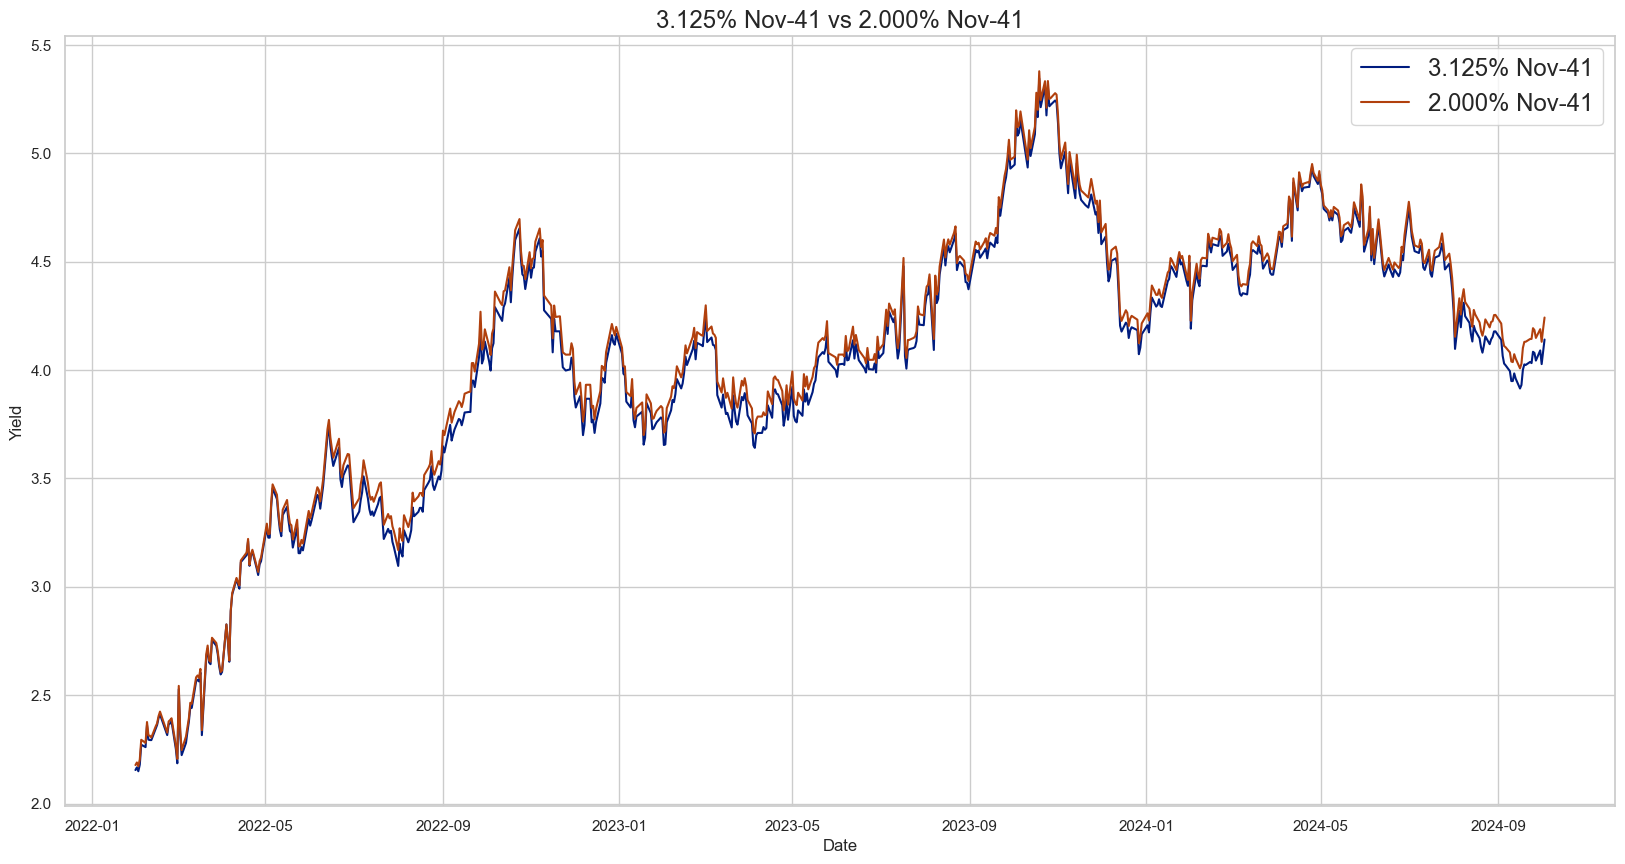

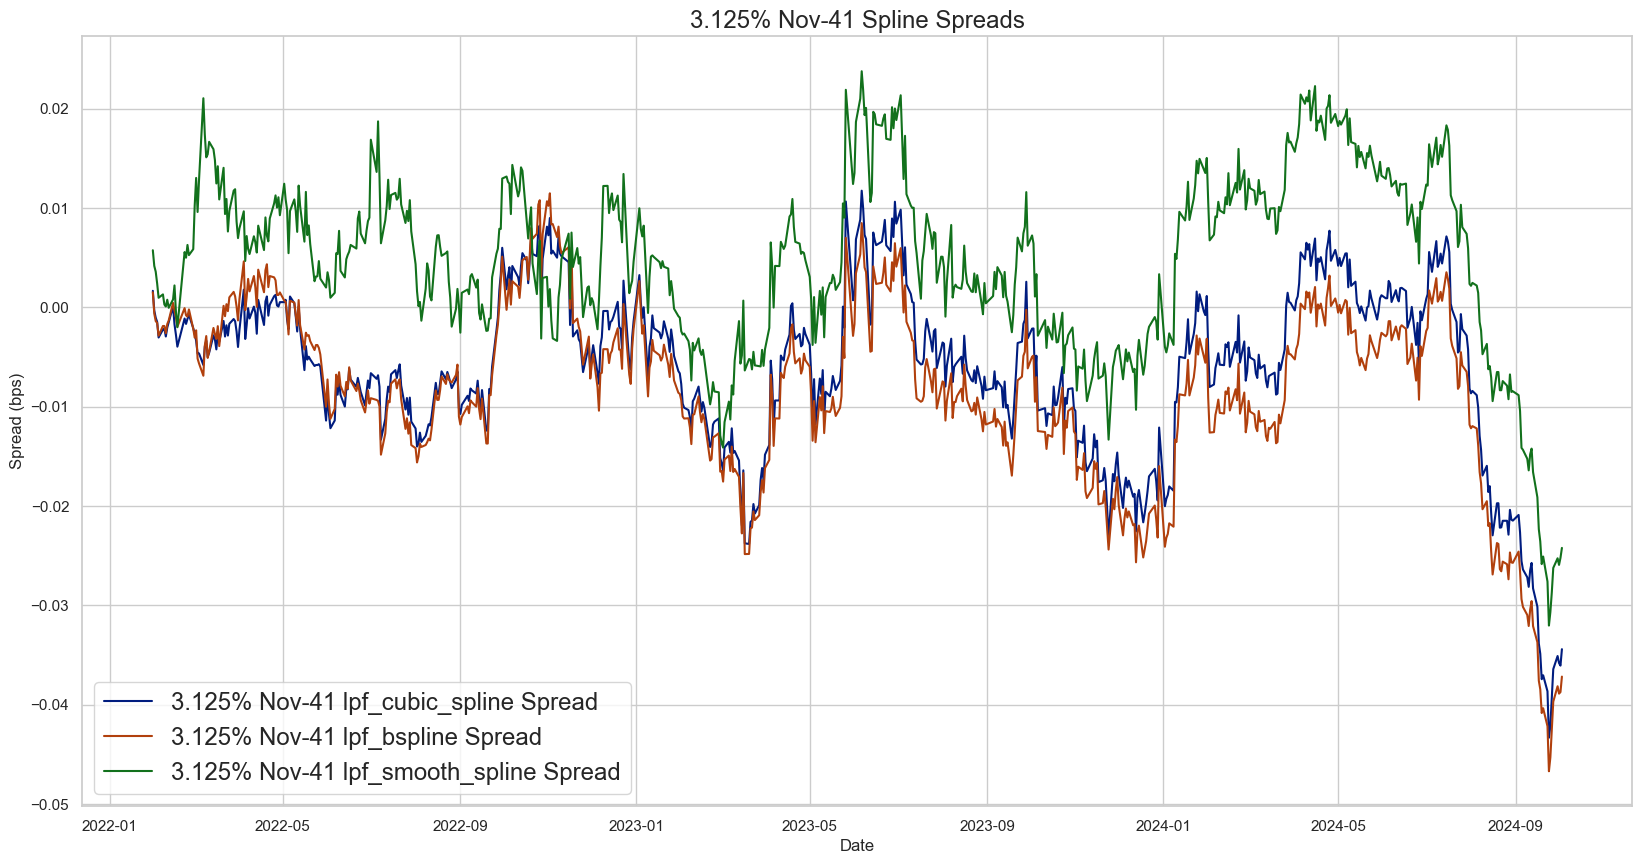

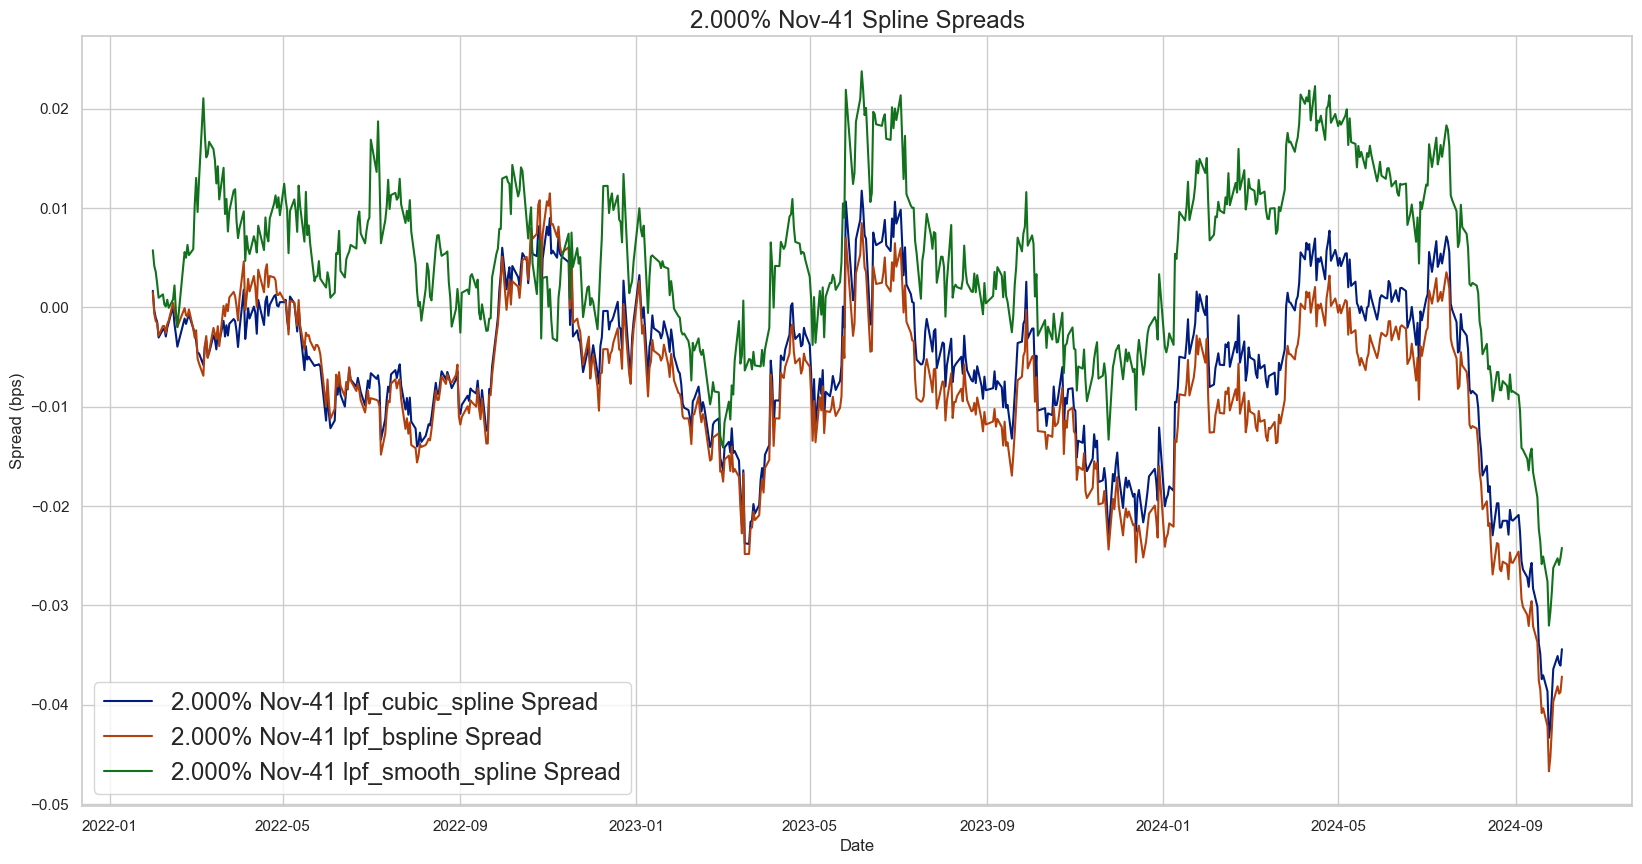

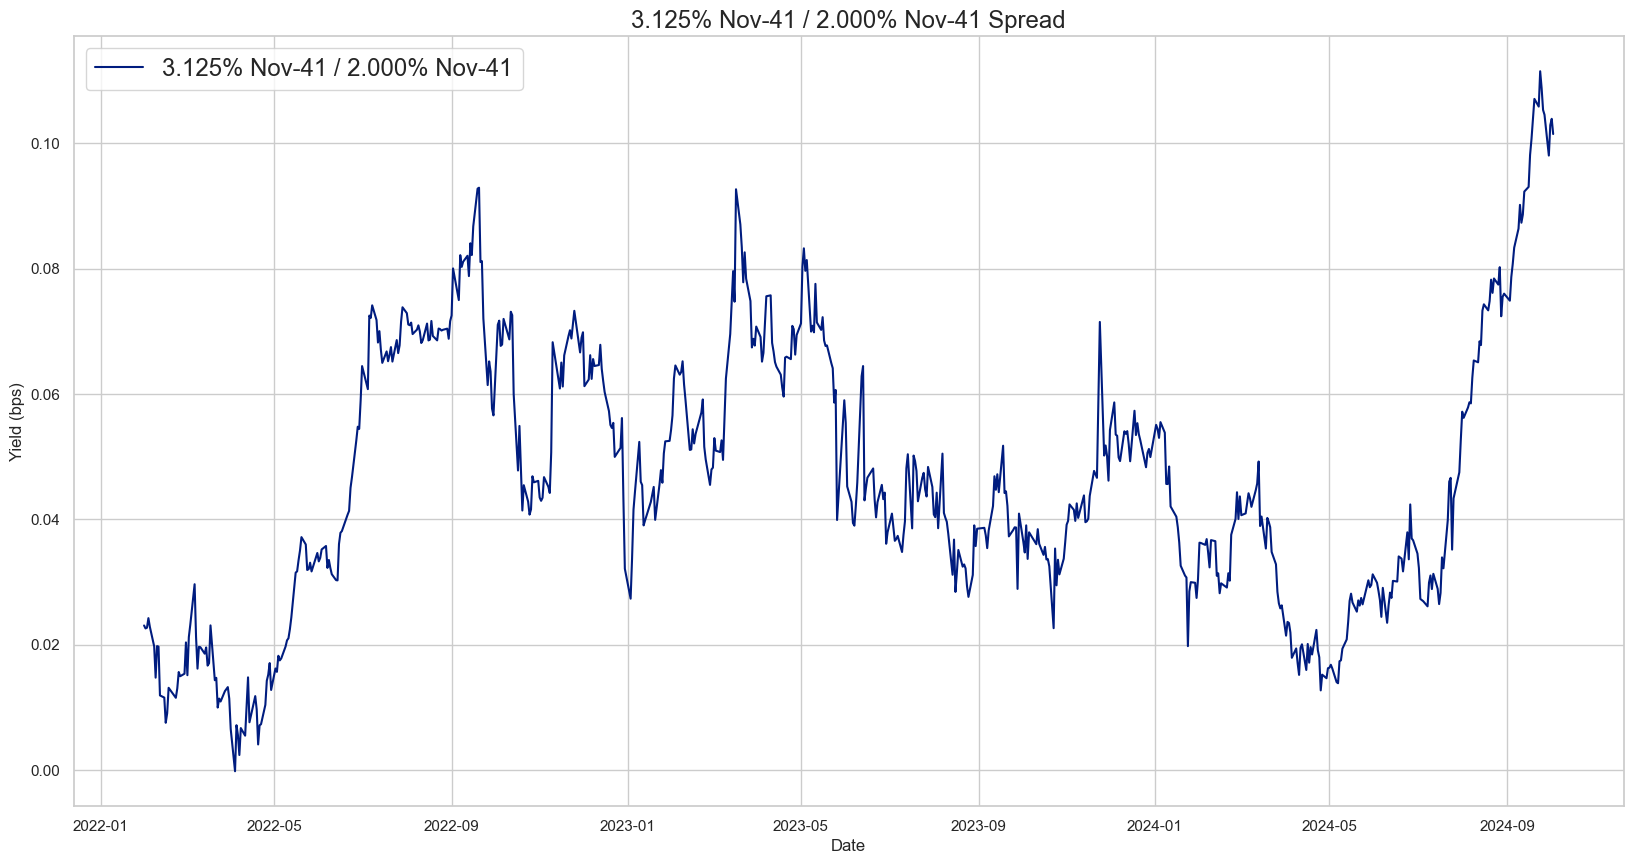

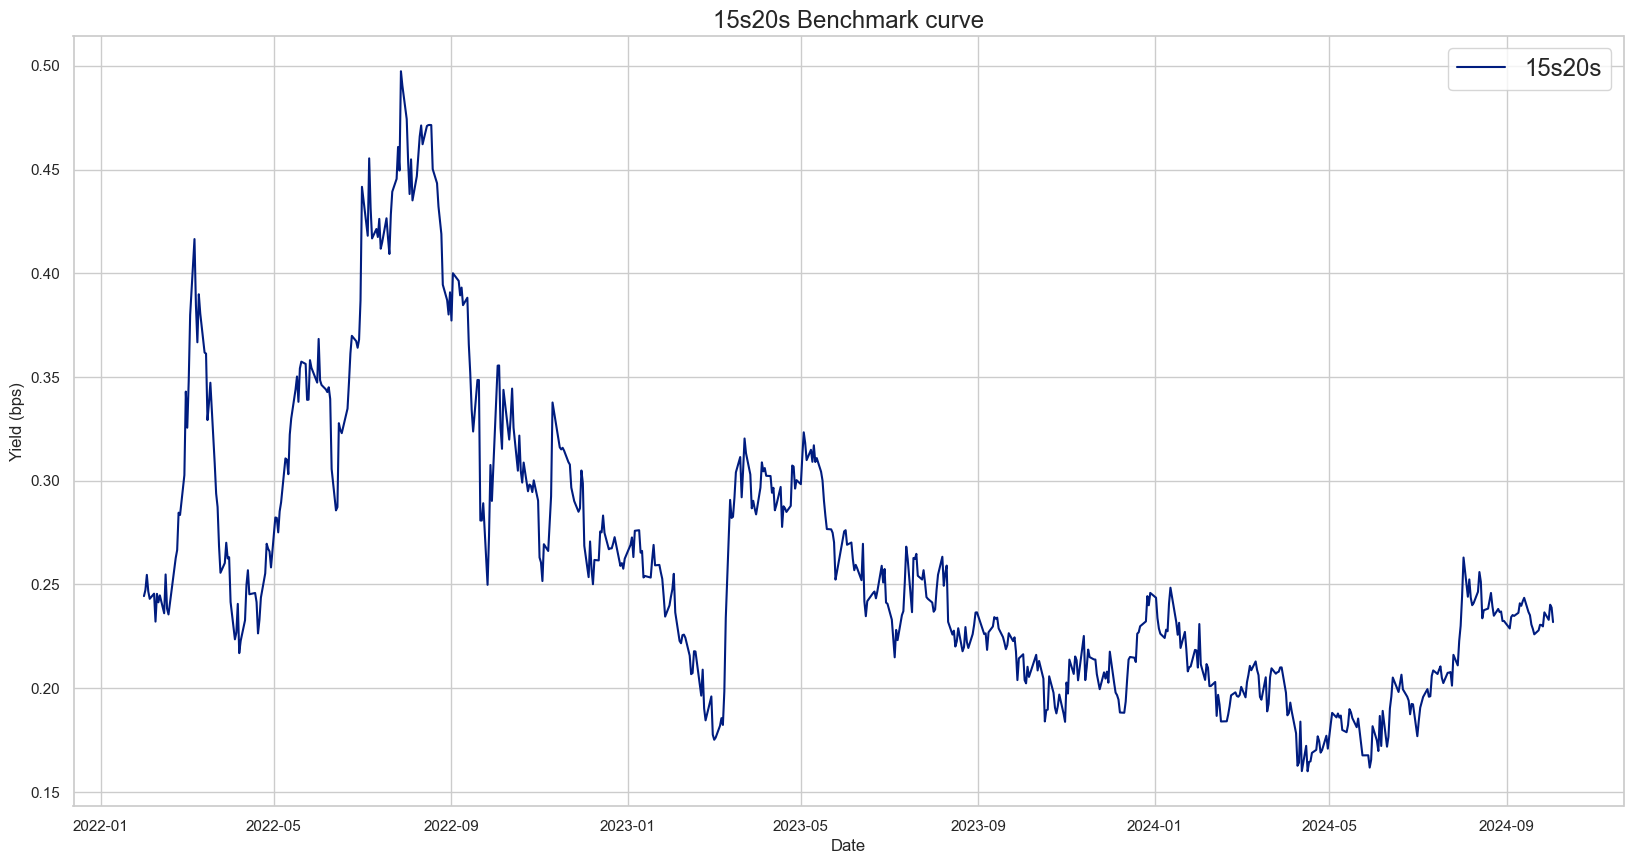

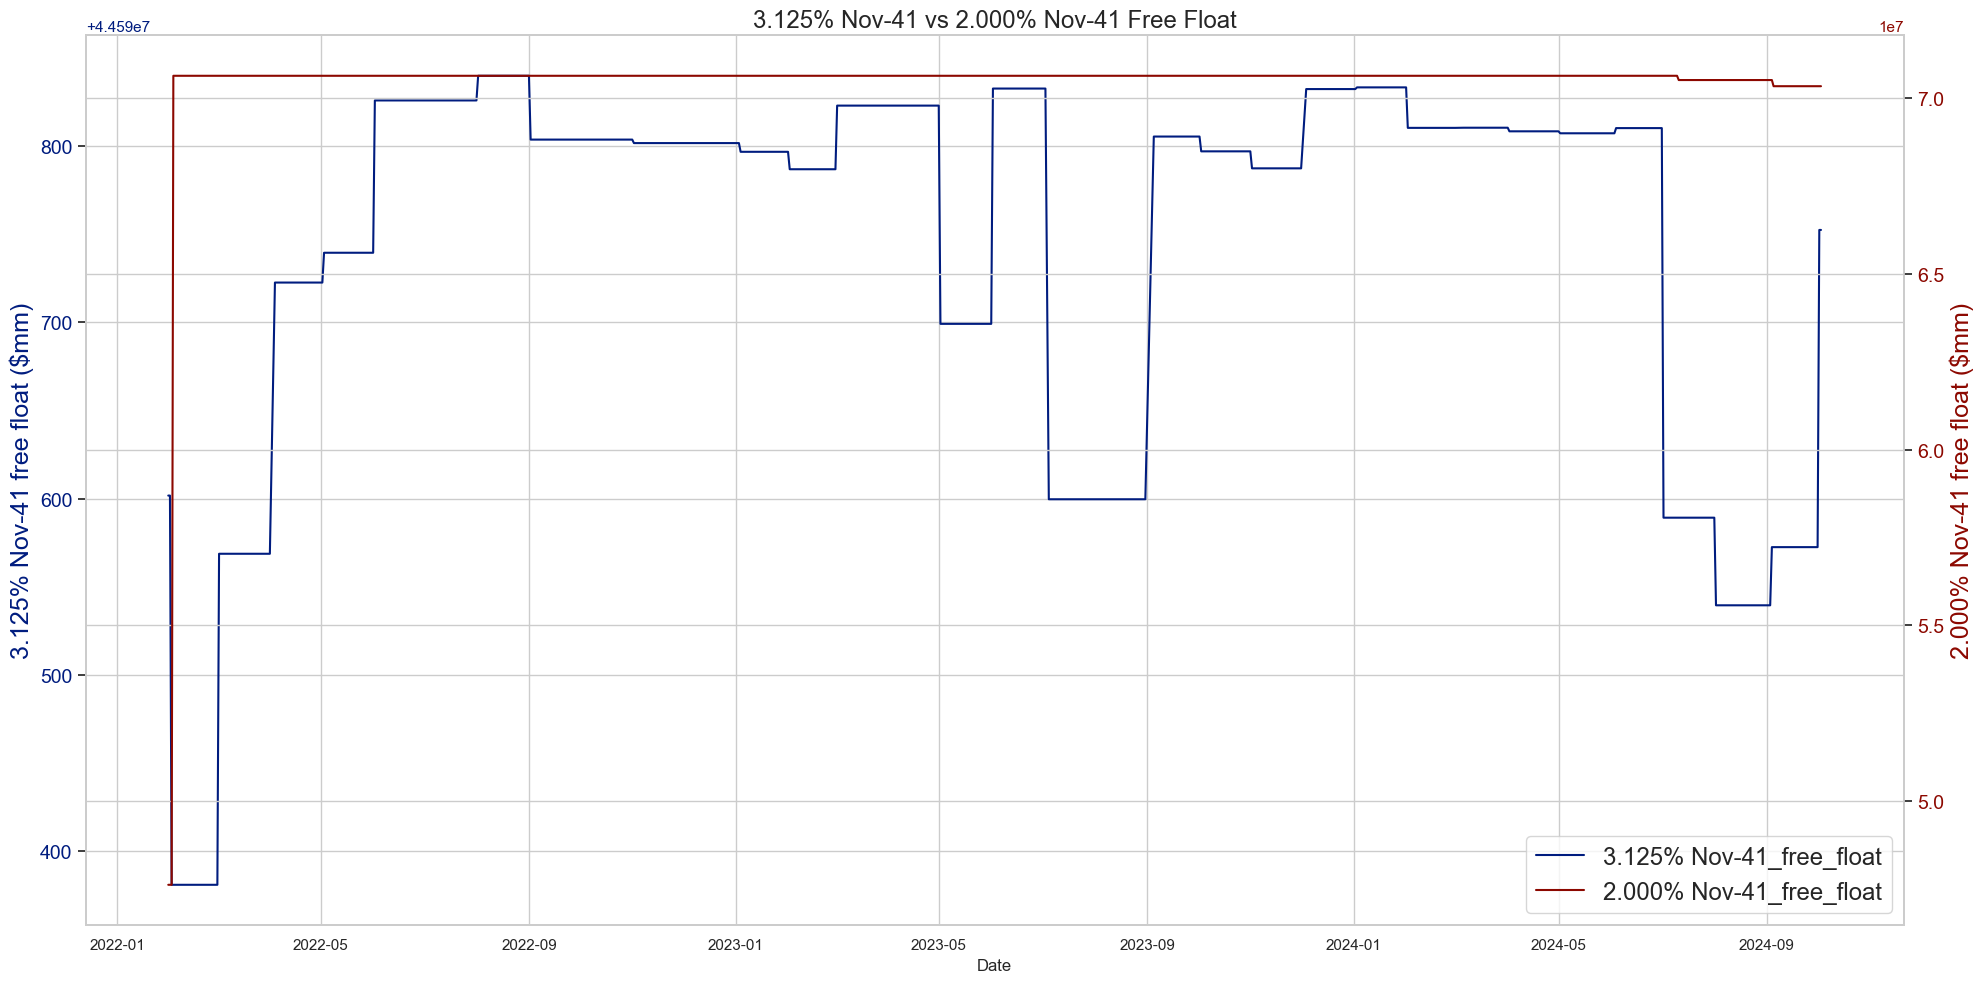

                                  OLS Regression Results                                 
Dep. Variable:     3.125% Nov-41 / 2.000% Nov-41   R-squared:                       0.156
Model:                                       OLS   Adj. R-squared:                  0.154
Method:                            Least Squares   F-statistic:                     122.4
Date:                           Sat, 05 Oct 2024   Prob (F-statistic):           3.18e-26
Time:                                   23:29:26   Log-Likelihood:                 1668.2
No. Observations:                            666   AIC:                            -3332.
Df Residuals:                                664   BIC:                            -3323.
Df Model:                                      1                                         
Covariance Type:                       nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------

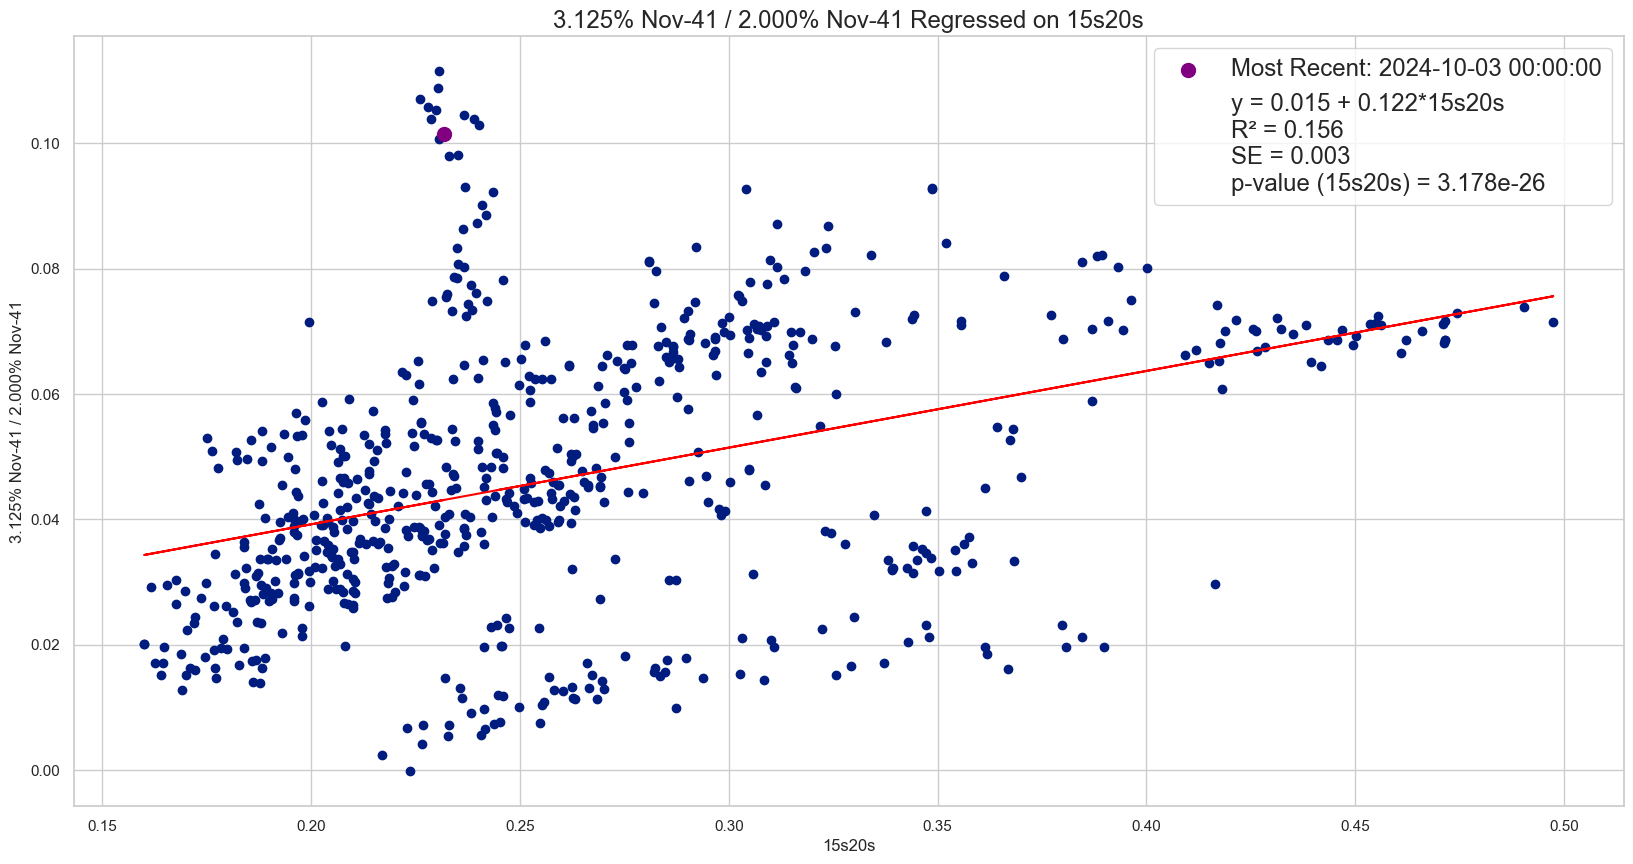

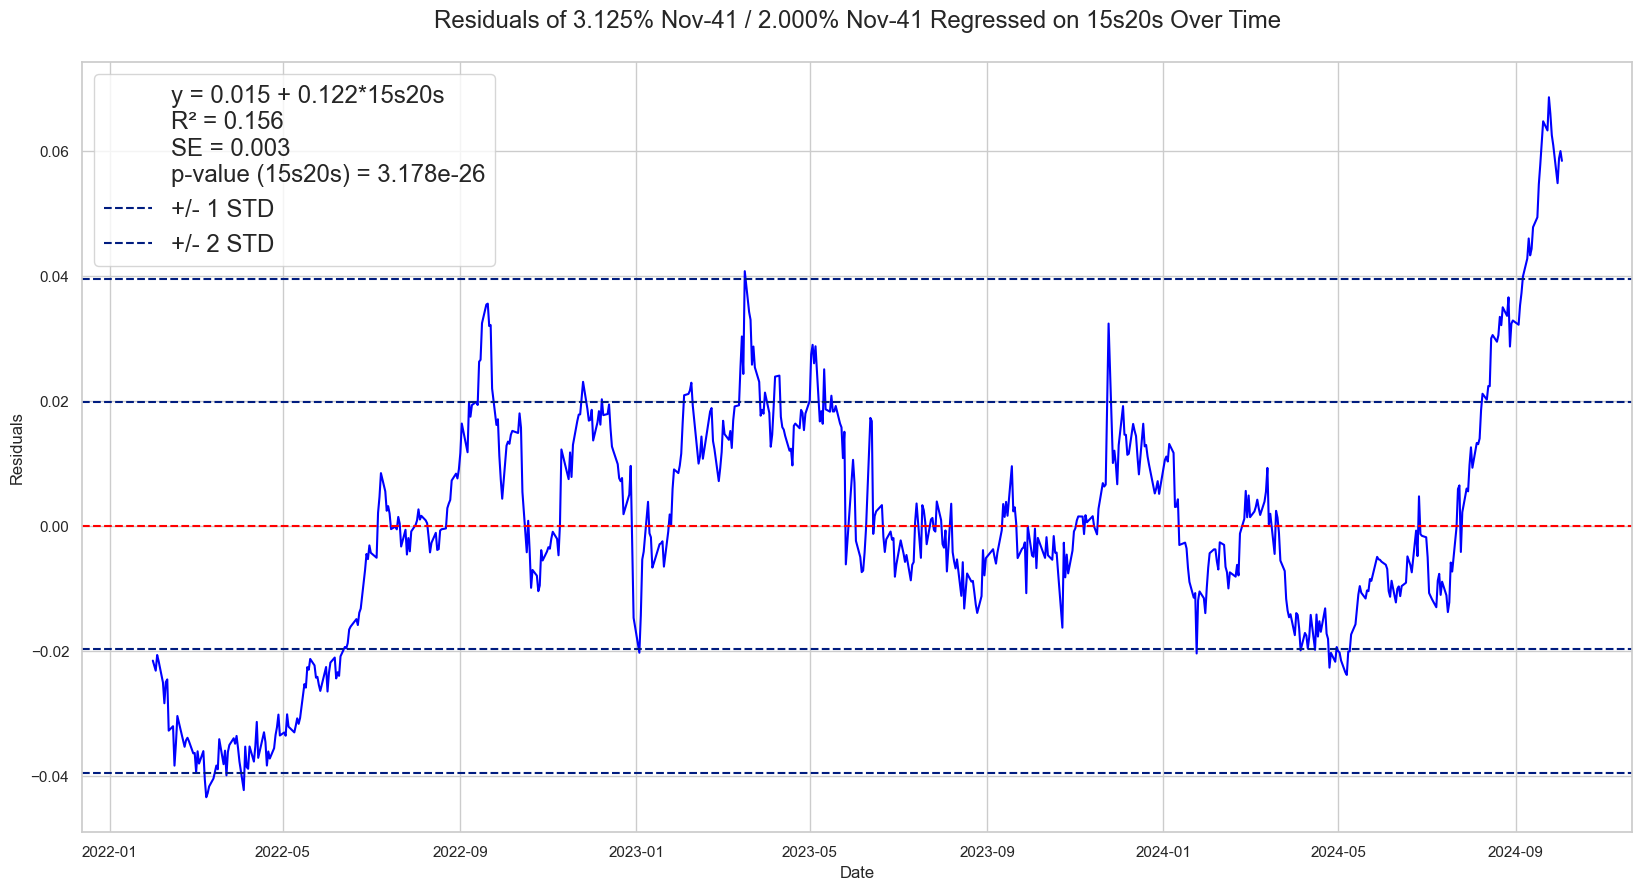

Using lpf_cubic_spline for UST Metrics Calcs


3.125% Nov-41 Metrics Calc: 666it [00:20, 32.61it/s]
2.000% Nov-41 Metrics Calc: 666it [00:20, 32.94it/s]


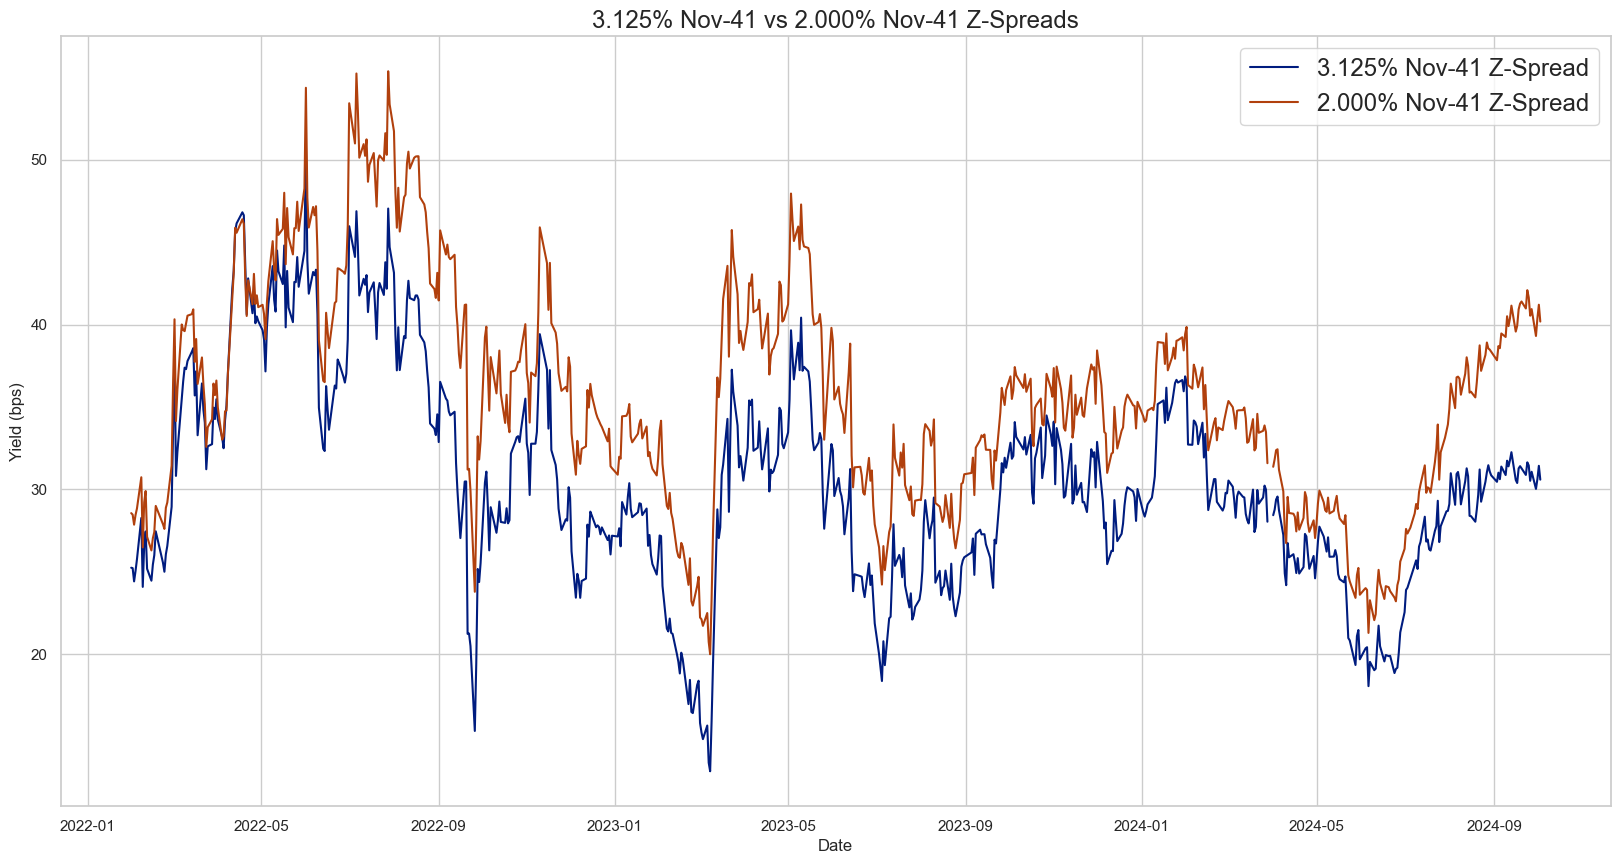

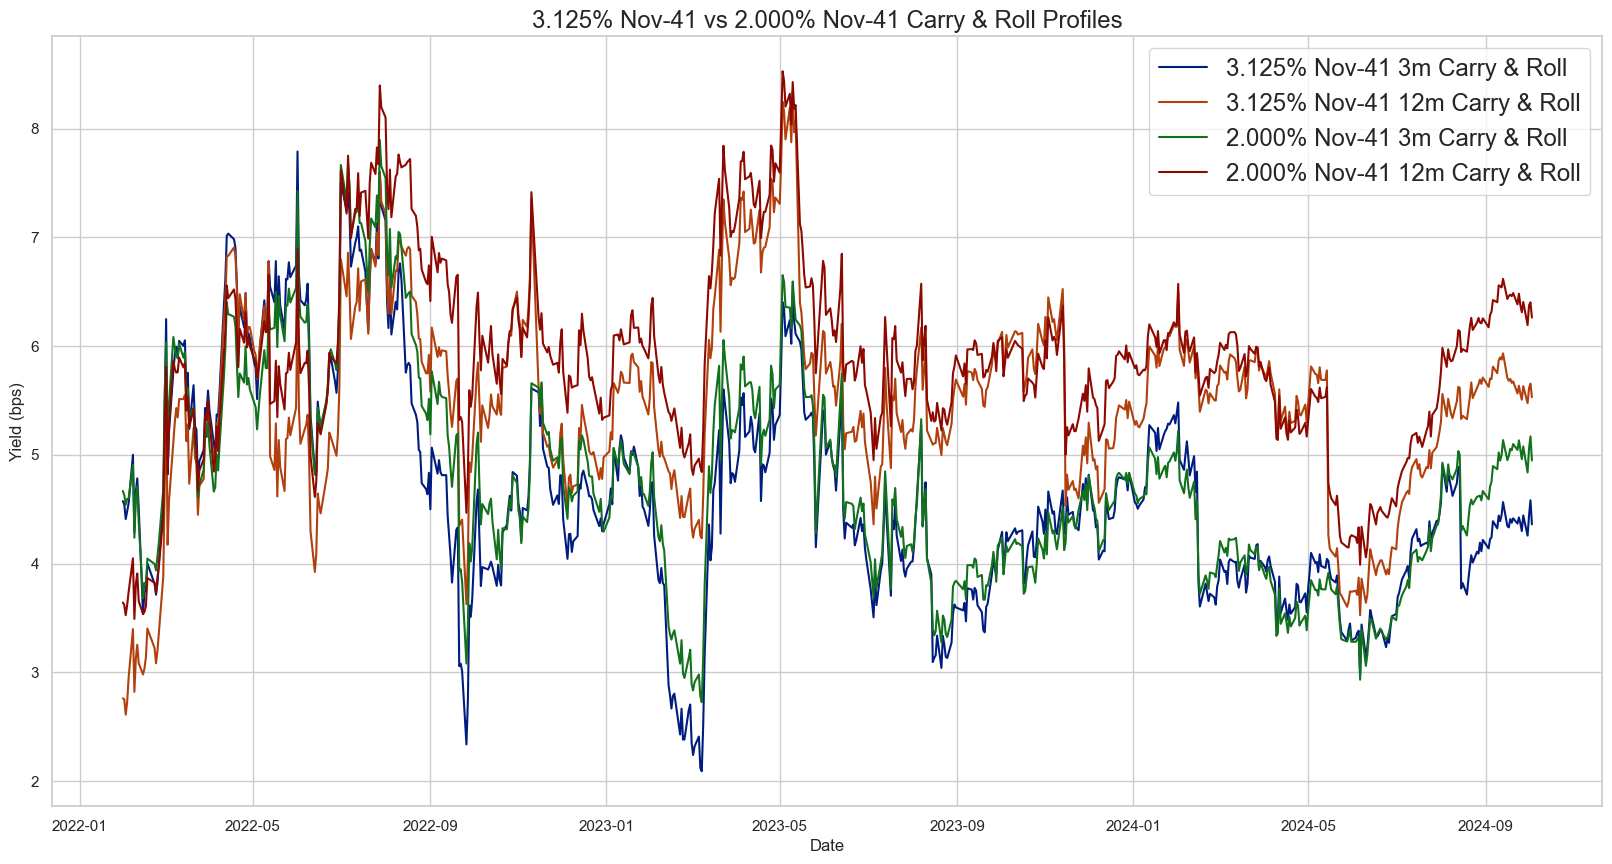

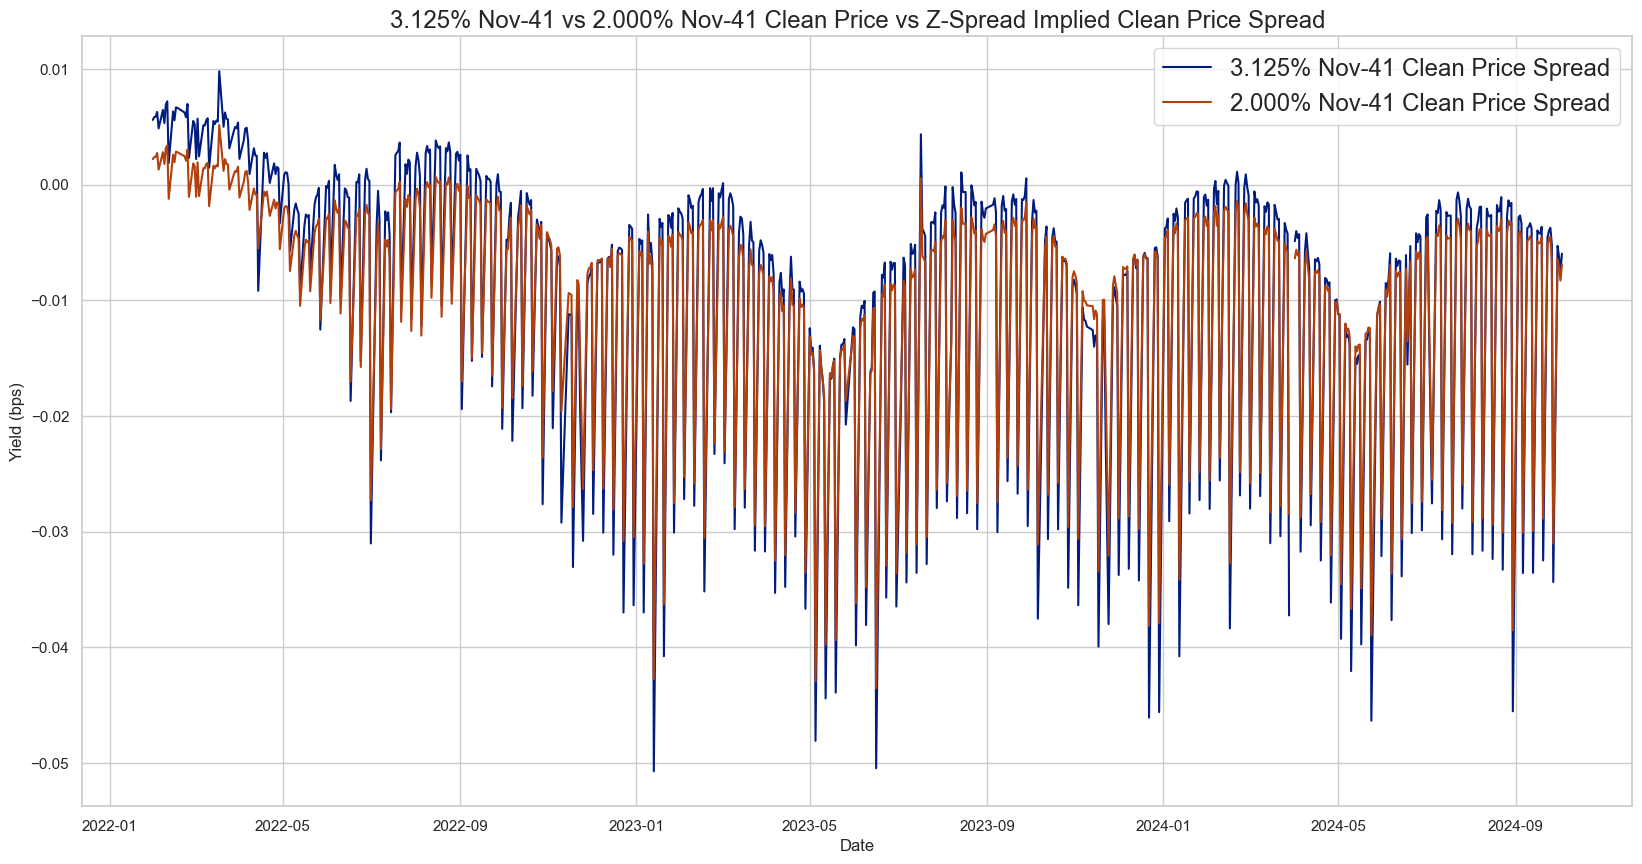

In [65]:
label1 = "3.125% Nov-41"
label2 = "2.000% Nov-41"

cusip_spread_rv_regression(
    curve_data_fetcher=curve_data_fetcher,
    label1=label1,
    label2=label2,
    cusip_timeseries=cusip_timeseries,
    fitted_splines_timeseries_dict={
        "lpf_cubic_spline": fitted_cubic_spline_timeseries,
        "lpf_bspline": fitted_bspline_timeseries,
        "lpf_smooth_spline": fitted_smooth_spline_timeseries,
    },
    benchmark_tenor_1=15,
    benchmark_tenor_2=20,
)